In [33]:
import pandas as pd
import os
import dask
import dask.dataframe as dd
from dask.multiprocessing import get
from dask import delayed, compute
from dask.diagnostics import ProgressBar
import requests
# For downloading galleries, a command line tool will be needed:
#!python3 -m pip install -U gallery-dl

In [34]:
os.chdir("/Users/iandouglas/Projects/Repos/generative-ai/")

In [35]:
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

12

In [36]:
d = pd.read_csv("data/flat/p_notself_clean.csv", index_col = None)
d.head()

,id,author,selftext,title,url,thumbnail,created_utc,is_self,media,over_18,domain,download_method,clean_url
0,i7j83,bronzehydra,NaN,The less lustrous hydra 4-month progress pics,http://imgur.com/Zzj9Z,http://thumbs.reddit.com/t3_i7j83.png,1308864675,False,None,False,imgur.com,url,http://imgur.com/Zzj9Z.jpg
1,i7g9t,[deleted],NaN,SquatzOatz 1 year progress,http://i.imgur.com/9HRwh.jpg,default,1308858971,False,None,False,i.imgur.com,url,http://i.imgur.com/9HRwh.jpg
2,i7g0g,LifeStartsNow,NaN,I hate this dress (dont bridesmaids always hat...,http://i.imgur.com/uxBnu.jpg,http://thumbs.reddit.com/t3_i7g0g.png,1308858497,False,None,False,i.imgur.com,url,http://i.imgur.com/uxBnu.jpg
3,i7fh2,Jillatha,NaN,My progress pic :) 251lbs-137lbs :),http://i.imgur.com/eMdlj.jpg,http://thumbs.reddit.com/t3_i7fh2.png,1308857538,False,None,False,i.imgur.com,url,http://i.imgur.com/eMdlj.jpg
4,i7ejj,[deleted],NaN,Here is my most current before/after pics.,http://i.imgur.com/KOjSB.jpg,default,1308855704,False,None,False,i.imgur.com,url,http://i.imgur.com/KOjSB.jpg


#### Define functions to download images

If the request will be sent to an image directly, use `requests`, otherwise (for galleries) use the command line tool `gallery-dl`.

In [45]:
# Function to download from url to an image
def download_image(url, id_, save_dir = 'data/image_extraction/progresspics/url'):
    filepath = os.path.join(save_dir, f"{id_}.jpg")
    if not os.path.exists(filepath):
        try:
            response = requests.get(url)
            response.raise_for_status()  # Raise an HTTPError for bad responses
            #print(f'{timestamp_()}: Trying to save {filepath}')
            with open(filepath, 'wb') as f:
                f.write(response.content)
                f.close()
                #print(f'{timestamp_()}: Save succesful at {filepath}')
        except requests.RequestException as e:
            pass # print(f"Failed to download image from {url}. Error: {e}")
    else:
        pass # print(f"{filepath} already exists.")

# gallery extraction
def gallery_extraction(url,
                       id_, 
                       save_dir = 'data/image_extraction/progresspics/gallery'):
    # Compose and execute command
    dest = os.path.join(save_dir, id_) # post-specific directory
    subproc = ['gallery-dl', '-q', f'-D {dest}', url]
    res = subprocess.run(subproc, stdout = subprocess.DEVNULL, stderr = subprocess.DEVNULL)
    # Return nothing

# Setup a function to operate on a dask partition df
def map_download(df_):
    return df_.apply(download_row, axis = 1)

# Setup function to download each row
def download_row(row, complete_file = "logs/complete_list.log"):
    if row['download_method'] == 'gallery':
        os.system(f"echo {row.id} >> {complete_file}")
        gallery_extraction(row['clean_url'], row['id'])
    elif row['download_method'] == 'url':
        os.system(f"echo {row.id} >> {complete_file}")
        download_image(row['clean_url'], row['id'])

#### Setup dask partitions

In [46]:
ddf = dd.from_pandas(d, npartitions = 30)
task = ddf.map_partitions(map_download, meta = (None, None))

/Users/iandouglas/miniconda3/lib/python3.10/site-packages/dask/dataframe/utils.py:312: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series([], dtype=dtype, name=name, index=index)


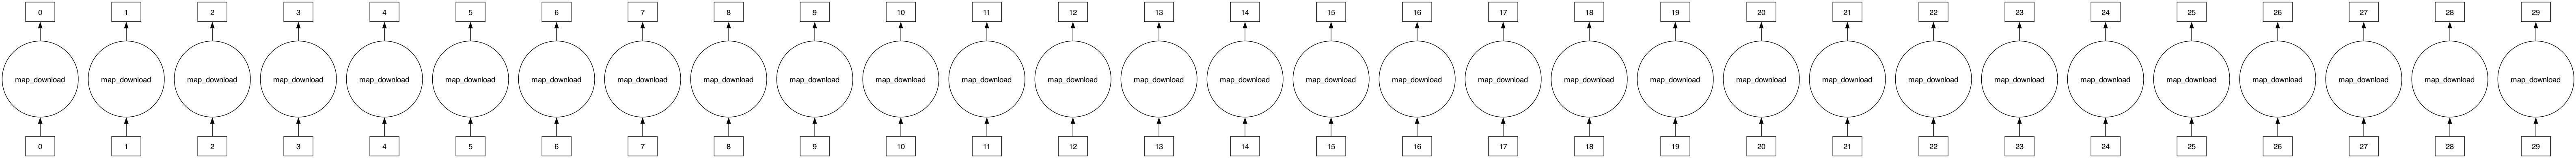

In [47]:
task.visualize()

In [ ]:
with ProgressBar():
    task.compute()

[                                        ] | 0% Completed | 19m 51sss